In [0]:
pip install plotly

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql.functions import corr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [0]:
data = {
    "Estado": ["Bahia", "Sergipe", "Alagoas", "Pernambuco", "Paraíba", "Rio Grande do Norte", "Ceará", "Piauí", "Maranhão"],
    "Atendimento_Agua": [80.55, 91.62, 77.21, 86.65, 76.99, 79.69, 70.30, 72.84, 56.50],
    "Esgoto_Tratado": [48.79, 38.14, 14.75, 30.10, 38.66, 29.78, 36.57, 18.84, 13.83],
    "Internacoes_Totais": [21764, 3104, 6153, 10012, 5102, 4369, 8793, 5158, 38000],
    "Internacoes_Criancas": [6177, 1086, 1958, 1766, 1107, 1018, 2479, 1622, 5400],
    "Perdas_Agua": [41.66, 34.71, 19.61, 34.20, 40.02, 30.15, 29.58, 19.36, 59.09]
}

df = pd.DataFrame(data)
df.columns = ["State", "Water Service Coverage", "Treated Sewage", "Total Hospitalizations", "Child Hospitalizations", "Water Losses"]

# ----------------------------------------
# Gráfico 1: Água vs. Esgoto Tratado (Barras Agrupadas)
# ----------------------------------------

fig1 = px.bar(
    df,
    x="State",
    y=["Water Service Coverage", "Treated Sewage"],
    title="Disparity between Water and Sewage Treatment Coverage",
    labels={"value": "%", "variable": "Indicador"},
    barmode="group",
    color_discrete_sequence=["#ff7f0e", "#1f77b4"],
    text_auto=".2f"
)

fig1.update_layout(
    xaxis_title="State",
    yaxis_title="Percentage (%)",
    xaxis_tickangle=-45,
    legend_title="Indicator"
)

# ----------------------------------------
# Gráfico 2: Internações Totais vs. Crianças (Barras + Linha)
# ----------------------------------------

fig2 = make_subplots(specs=[[{"secondary_y": True}]])

# Barras para internações totais
fig2.add_trace(
    go.Bar(
        x=df["State"],
        y=df["Total Hospitalizations"],
        name="Total Hospitalizations",
        marker_color="#d62728",
        text=df["Total Hospitalizations"],
        textposition="outside"
    ),
    secondary_y=False
)

# Linha para internações em crianças
fig2.add_trace(
    go.Scatter(
        x=df["State"],
        y=df["Child Hospitalizations"],
        name="Child Hospitalizations",
        line=dict(color="#2ca02c", width=3),
        mode="lines+markers"
    ),
    secondary_y=True
)

fig2.update_layout(
    title="Hospitalizations for Waterborne Diseases (Total vs. Children)",
    xaxis_title="State",
    xaxis_tickangle=-45,
    yaxis_title="Total Hospitalizations",
    yaxis2_title="Child Hospitalizations",
    legend_title="Category"
)

# ----------------------------------------
# Gráfico 3: Perdas de Água (Barras Horizontais)
# ----------------------------------------

fig3 = px.bar(
    df.sort_values("Water Losses", ascending=True),
    y="State",
    x="Water Losses",
    title="Water Distribution Losses by State",
    labels={"Water Losses": "% Loss", "State": ""},
    orientation="h",
    color="Water Losses",
    color_continuous_scale="viridis",
    text_auto=".2f"
)

fig3.update_layout(
    yaxis_categoryorder="total ascending",
    coloraxis_showscale=False
)

# ----------------------------------------
# Exibir todos os gráficos
# ----------------------------------------
fig1.show()
fig2.show()
fig3.show()

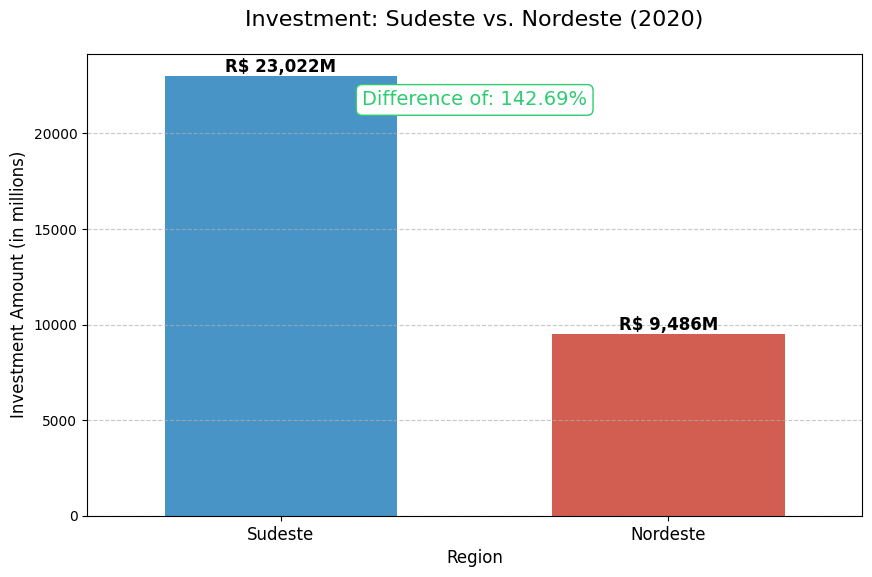

In [0]:
query = """
WITH Dados AS (
    SELECT 
        Regiao,
        valor_prod
    FROM 
        valor_bruto_agua
    WHERE 
        Regiao IN ('Sudeste', 'Nordeste')
)
SELECT
    MAX(CASE WHEN Regiao = 'Sudeste' THEN valor_prod END) AS Sudeste,
    MAX(CASE WHEN Regiao = 'Nordeste' THEN valor_prod END) AS Nordeste,
    ROUND(
        (MAX(CASE WHEN Regiao = 'Sudeste' THEN valor_prod END) - MAX(CASE WHEN Regiao = 'Nordeste' THEN valor_prod END)) 
        / MAX(CASE WHEN Regiao = 'Nordeste' THEN valor_prod END) * 100, 
        2
    ) AS Diferenca_Percentual
FROM 
    Dados
"""

df = spark.sql(query)
dados_pandas = df.toPandas()


df_plot = dados_pandas.melt(
    value_vars=['Sudeste', 'Nordeste'],
    var_name='Regiao',
    value_name='Valor_Investido'
)

diferenca_pct = dados_pandas['Diferenca_Percentual'].values[0]

# ----------------------------------------
# Gráfico 4: Sudeste vs. Nordeste (Barra e Anotação)
# ----------------------------------------

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Regiao',
    y='Valor_Investido',
    data=df_plot,
    palette=['#3498db', '#e74c3c'], 
    width=0.6
)


for index, row in df_plot.iterrows():
    ax.text(
        index,
        row['Valor_Investido'],
        f"R$ {row['Valor_Investido']:,.0f}M",  
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )


ax.annotate(
    f'Difference of: {diferenca_pct:.2f}%',
    xy=(0.5, 0.9),
    xycoords='axes fraction',
    ha='center',
    va='center',
    fontsize=14,
    color='#2ecc71',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='#2ecc71')
)


plt.title('Investment: Sudeste vs. Nordeste (2020)', fontsize=16, pad=20)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Investment Amount (in millions)', fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()